In [1]:
# references
# https://www.kaggle.com/code/rcushen/topic-modelling-with-lsa-and-lda

In [10]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

import seaborn as sns
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

Loading BokehJS ...

In [5]:
# Load the data file
url = 'https://raw.githubusercontent.com/lucascheng24/COMP4432ML-DataProduct-A_Million_News_Headlines/main/raw_data/abcnews-date-text.csv'

raw_data = pd.read_csv(url, parse_dates=[0], infer_datetime_format=True)

reindexed_data = raw_data['headline_text']
reindexed_data.index = raw_data['publish_date']

raw_data.head(10)

,publish_date,headline_text
0,2003-02-19,aba decides against community broadcasting lic...
1,2003-02-19,act fire witnesses must be aware of defamation
2,2003-02-19,a g calls for infrastructure protection summit
3,2003-02-19,air nz staff in aust strike for pay rise
4,2003-02-19,air nz strike to affect australian travellers
5,2003-02-19,ambitious olsson wins triple jump
6,2003-02-19,antic delighted with record breaking barca
7,2003-02-19,aussie qualifier stosur wastes four memphis match
8,2003-02-19,aust addresses un security council over iraq
9,2003-02-19,australia is locked into war timetable opp


In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1244184 entries, 0 to 1244183
Data columns (total 2 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   publish_date   1244184 non-null  datetime64[ns]
 1   headline_text  1244184 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 19.0+ MB


In [12]:
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
stop_words = text.ENGLISH_STOP_WORDS.union(punc)

In [15]:
type(list(stop_words))

list

In [16]:

desc = raw_data['headline_text'].values
vectorizer = TfidfVectorizer(stop_words = list(stop_words))
X = vectorizer.fit_transform(desc)

In [19]:
word_features = vectorizer.get_feature_names_out()
print(len(word_features))

105674


Tokenizing

In [20]:
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]

Vectorization with stop words

In [22]:
vectorizer2 = TfidfVectorizer(stop_words = list(stop_words), tokenizer = tokenize)
X2 = vectorizer2.fit_transform(desc)
word_features2 = vectorizer2.get_feature_names_out()
print(len(word_features2))

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'the

73341


In [23]:
vectorizer3 = TfidfVectorizer(stop_words = list(stop_words), tokenizer = tokenize, max_features = 1000)
X3 = vectorizer3.fit_transform(desc)
words = vectorizer3.get_feature_names_out()

K Means Clustering (Unsupervised)

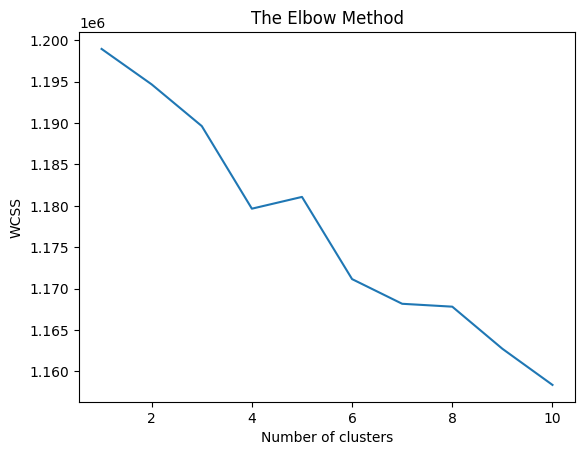

In [24]:
# select the best k by Elbow Method
# the analysis of Elbow point is from https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(X3)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('elbow.png')
plt.show()

7 Clusters (Elbow Point is k=7)

In [26]:
knn = KMeans(n_clusters = 7, n_init = 20)
knn.fit(X3)

common_words = knn.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : day, australia, test, anzac, vs, highlight, ash, second, box, live, honour, celebr, open, final, mark, world, grandstand, wrap, tiger, india, new, big, australian, aust, elect
1 : interview, extend, michael, nrl, john, david, smith, jame, andrew, mark, peter, paul, scott, afl, speak, clark, georg, johnson, white, william, polic, toni, cricket, brown, price
2 : polic, man, charg, plan, council, australia, court, kill, australian, govt, report, death, nsw, crash, face, warn, attack, sydney, water, urg, murder, fund, year, chang, wa
3 : new, zealand, year, law, case, plan, open, record, council, polic, australia, home, set, deal, hospit, announc, centr, hope, south, appoint, nsw, look, coronavirus, wa, covid
4 : say, polic, need, govt, expert, minist, trump, mp, plan, australia, union, council, report, govern, labor, pm, wont, group, opposit, public, new, chang, wa, time, lawyer
5 : win, award, cup, titl, open, gold, stage, world, final, tour, elect, australia, lead, seri, claim, auss

In [29]:
y_kmeans = knn.fit_predict(X3)

Plot